# Creation of the CNN

### Importations 

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl


from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import gridspec




print(torch.__version__)

1.0.1.post2


### The Aim 

Some explation about the purpose of this project.

### The Data

Some insight about the data.

In [21]:
path = "/Users/youssef/Documents/EPFL/DataSet/Training_Set/"
i = 0
data_matrix = np.zeros([4,4,129,390])
for i in range(4):
    name_matrix = 'phase_matrix/Phase_matrix-{}'.format(i)
    fileName_matrix = path + name_matrix
    fileObject2 = open(fileName_matrix, 'rb')
    matrix_loaded = pkl.load(fileObject2)
    fileObject2.close()
    data_matrix[i] = matrix_loaded
data_matrix.shape    

(4, 4, 129, 390)

In [22]:
data_matrix = torch.from_numpy(data_matrix)
data_matrix = data_matrix.view(-1,390,4,129)
data_matrix.shape

torch.Size([4, 390, 4, 129])

In [27]:
entry_0 = input_matrix[0,2,:,:]
entry_1 = input_matrix[:,:,1]
entry_0.shape

torch.Size([4, 129])

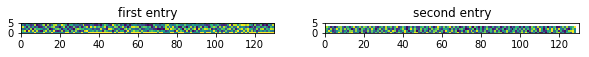

In [6]:
fig = plt.figure(figsize=(10,100))
           
ax1 = plt.subplot(2,2,1)
ax1.imshow(entry_0)
ax1.set_xlim([0, 130])
ax1.set_ylim([0, 5])
ax1.set_title('first entry')


ax2 = plt.subplot(2,2,2)
ax2.imshow(entry_1)
ax2.set_xlim([0, 130])
ax2.set_ylim([0, 5])
ax2.set_title('second entry')


plt.show()

In [13]:
target_0 = torch.zeros(37, dtype=torch.float64)
target_0[8] = 1
target_0 = target_0.expand(390,37)
target_0.shape

torch.Size([390, 37])

In [14]:
def prep_targets(index):
    target = torch.zeros(37, dtype=torch.float64)
    target[index] = 1
    taget = target.expand(390,37)
    return target

In [ ]:
indices = np.array([9,9,3,1])
for i in range(4):
    

# Architecture 1.0 : vanilla CNN for DOA 

In this section, we will focus on building a vanilla CNN in order to recognize the directions of arrival of the sound in a specific room. Once done, we will then compare "by hand" the labelel dataset to the predicted values. This is the most basic setup and will try to improve latter.

## 1.1 Creating Model

In [ ]:
class Net(nn.Module):
    def __init__(self,nb_hidden = 512):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=2)
        self.conv3 = nn.Conv2d(64 , 64, kernel_size=2)
        self.fc1 = nn.Linear(8064, nb_hidden) # (1x8064) being the dim of the censor obtained by flattening the output of the 3rd CL.
        self.fc2 = nn.Linear(nb_hidden, 37)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = f.softmax(self.fc2(x),dim=0)
        return x

### Preparing the Data

In [ ]:
def prep_input_vanilla(train_input):
    new_train_input = train_input.view(-1,4,129)
    return new_train_input

In [ ]:
train_data = prep_input_vanilla(input_matrix)
train_data.shape

In [ ]:
def prep_labels_vanilla(train_input):
    new_train_input = train_input.view(-1,390,37)
    return new_train_input

In [ ]:
train_labels = prep_labels_vanilla(target)
train_labels.shape

In [ ]:
Variable(train_labels)

In [ ]:
Variable(train_data)

### End of Sanity check:

## 1.2 Training the model

In [ ]:
mini_batch_size = 100 
nb_epochs = 25
eta = 0.001 #learning rate
#criterion = nn.MSELoss() # MeanSquaredloss
criterion = torch.nn.CrossEntropyLoss() #Cross Entropy

In [ ]:
def train_model(model, train_input, train_target, mini_batch_size, criterion, nb_epochs, eta):
    
    optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = 0.95) #Stochastic gradient descent
    
    for e in range(0, nb_epochs):
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            target = train_target.narrow(0, b, mini_batch_size)
            #loss = criterion(output,target)
            loss = criterion(output,target.max(1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(e, loss.data.item())
    